<a href="https://colab.research.google.com/github/krymsza/combustion-simulation/blob/main/CH3NO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combustion of mixtures with different concentrations of nitromethane and air.

#### env setup

In [ ]:
!apt-get -qq update -y
!apt-get -qq install -y python3-software-properties
!apt-add-repository -y ppa:speth/cantera > /dev/null 2>&1
#!apt-get -qq install -y cantera #-python3

In [ ]:
!pip install cantera

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 27.4 MB/s eta 0:00:00


##### imports

In [ ]:
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
import os
import csv

In [ ]:
#%matplotlib inline
#%config InlineBackend.figure_formats = ["svg"]

plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 150

plt.style.use("bmh")

##### downloading yaml files with nitromethane data

In [ ]:
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from pathlib import Path
import os

def download_and_save(file_name, file_id):
  downloaded = drive.CreateFile({'id': file_id})
  # fetch file
  downloaded.FetchContent()
  # write file
  with open(file_name,'wb') as f:
       f.write(downloaded.content.read())

  print(f'Saved {file_name}')

FILE_NAME, FILE_ID = ['file_name', 'file_id']

In [ ]:
#https://drive.google.com/file/d/11sqBetyJwxAl5lKh2Xcps5MGUusZZ6xf/view?usp=share_link

In [ ]:
dataset_path = Path('/usr/local/lib/python3.10/dist-packages/cantera/data/'); dataset_path
!mkdir -p $dataset_path
#!ls -la $dataset_path

In [ ]:
file = {FILE_NAME: 'Fuller.yaml', FILE_ID: '11sqBetyJwxAl5lKh2Xcps5MGUusZZ6xf'}
file_path = dataset_path / file[FILE_NAME]
download_and_save(file_path, file[FILE_ID])

Saved /usr/local/lib/python3.10/dist-packages/cantera/data/Fuller.yaml


##### create solution with fuller file

In [ ]:
gas = ct.Solution('Fuller.yaml')

In [ ]:
ct.suppress_thermo_warnings()

#### charts


In [ ]:
def plot(states, phi):
  plt.figure(figsize=(8, 6))
  plt.subplot(2, 2, 1)
  h = plt.plot(states.t, states.T, 'g-')
  ax = plt.gca()
  ax.set_xlim([1.920, 1.923])
  plt.xlabel('Time (s)')
  plt.ylabel('Temperature (K)')

  plt.subplot(2, 2, 2)
  plt.plot(states.t, states.P / 1e5, 'g-')
  ax = plt.gca()
  ax.set_xlim([1.920, 1.923])
  plt.xlabel('Time (s)')
  plt.ylabel('Pressure (Bar)')

  plt.subplot(2, 2, 3)
  plt.plot(states.t, states.V, 'g-')
  ax = plt.gca()
  ax.set_xlim([1.920, 1.923])
  plt.xlabel('Time (s)')
  plt.ylabel('Mass (kg)')

  plt.subplot(2, 2, 4)
  plt.plot(states.t, states.HP[0], 'g-')
  ax = plt.gca()
  ax.set_xlim([1.920, 1.923])
  plt.xlabel('Time (s)')
  plt.ylabel('Enthlapy (J/kg)')

  plt.figlegend(h, ['combustor'], loc='lower right')
  plt.tight_layout()
  plt.show()

  # gas composition-----------------------------------------------------------------------------------
  fig, ax = plt.subplots()
  ax.plot(states.t, states('OH').X, label='OH')
  ax.plot(states.t, states('CH3NO2').X, label='CH3NO2')
  ax.plot(states.t, states('H').X, label='H')
  ax = plt.gca()
  ax.set_xlim([1.920, 1.923])
  ax.legend(loc=0)
  ax.set_ylabel('$X_i$ [-]')
  ax.set_xlabel(r'time[s]')
  plt.savefig(str(phi)+'_composition_1_plus.png')
  plt.show()

  xticks = np.arange(0, 0.18, 0.02)
  fig, ax = plt.subplots()
  ax.plot(states.t, states('N2O').X, label='N2O')
  ax.plot(states.t, states('NO2').X, label='NO2')
  ax.plot(states.t, states('NO').X, label='NO')
  ax = plt.gca()
  ax.set_xlim([1.920, 1.923])
  ax.legend(loc=0)
  ax.set_ylabel('$X_i$ [-]')
  ax.set_xlabel(r'time[s]')
  plt.savefig(str(phi)+'_composition_2_plus.png')
  plt.show()

  xticks = np.arange(0, 0.18, 0.02)
  fig, ax = plt.subplots()
  ax = plt.gca()
  ax.set_xlim([1.920, 1.923])
  ax.plot(states.t, states('O2').X, label='O2')
  ax.plot(states.t, states('N2').X, label='N2')
  ax.plot(states.t, states('CH3NO2').X, label='CH3NO2')
  ax.legend(loc=0)
  ax.set_ylabel('$X_i$ [-]')
  ax.set_xlabel(r'time[s]')
  plt.savefig(str(phi)+'_composition_3_plus.png')
  plt.show()

  xticks = np.arange(0, 0.18, 0.02)
  fig, ax = plt.subplots()
  ax.plot(states.t, states('H2O').X, label='H2O')
  ax.plot(states.t, states('CO2').X, label='CO2')
  ax.plot(states.t, states('CO').X, label='CO')
  ax = plt.gca()
  ax.set_xlim([0.0, 4.0])
  ax.legend(loc=0)
  ax.set_ylabel('$X_i$ [-]')
  ax.set_xlabel(r'time[s]')
  plt.savefig(str(phi)+'_composition_4.png')
  plt.show()

# Gaussian pulse

In [ ]:
def gaussian(t):
  igniter_total = 1.0e-08
  width = 0.1  #[s]
  t0 = 1.0  #pulse peak [s]
  amplitude = igniter_total / (width * np.sqrt(2*np.pi))
  return amplitude * np.exp(-(t-t0)**2 / (2*width**2))

In [ ]:
data = []
dt =[]
npoints = 2000
phi = np.linspace(0.0, 2.0, npoints)
for i in range(npoints):
  data.append(gaussian(phi[i]))

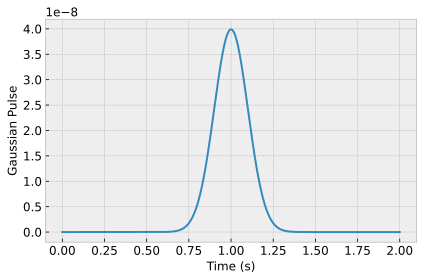

In [ ]:
plt.figure(figsize=(6, 4))
h = plt.plot(phi, data)
ax = plt.gca()
plt.xlabel('Time (s)')
plt.ylabel('Gaussian Pulse')
plt.savefig('gaussian.png')

# **phi = 1.0**

In [ ]:
gas = ct.Solution('Fuller.yaml')
fuel_species = 'CH3NO2'
npoints = 1
phi = np.linspace(1.0, 1.0, npoints)

#IGNITER
gas.TPX = 1000, ct.one_atm, 'H:1.0'
igniter = ct.Reservoir(gas)

def igniter_mdot(t):
  igniter_total = 1.0e-08
  width = 0.1  #[s]
  t0 = 1.0  #pulse peak [s]
  amplitude = igniter_total / (width * np.sqrt(2*np.pi))
  return amplitude * np.exp(-(t-t0)**2 / (2*width**2))

for i in range(npoints):
    gas.set_equivalence_ratio(phi=phi[i], fuel=fuel_species, oxidizer='O2:1.0, N2:3.76')
    gas.TP = 700, ct.one_atm
    gas()

    combustor = ct.Reactor(gas)
    combustor.volume = 0.0005
    igniter_mfc = ct.MassFlowController(igniter, combustor, mdot = igniter_mdot)

    sim = ct.ReactorNet([combustor])
    sim.rtol = 1.0e-16
    states_10 = ct.SolutionArray(gas, extra=['t', 'V'])

    n=0
    while sim.time < 10:
      sim.step()
      n+=1
      states_10.append(combustor.thermo.state, t=sim.time, V=combustor.mass)


  gas:

       temperature   700 K
          pressure   1.0132e+05 Pa
           density   0.6249 kg/m^3
  mean mol. weight   35.895 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy            -34872       -1.2517e+06  J
   internal energy       -1.9702e+05       -7.0718e+06  J
           entropy            7067.4        2.5368e+05  J/K
    Gibbs function        -4.982e+06       -1.7883e+08  J
 heat capacity c_p            1289.8             46298  J/K
 heat capacity c_v            1058.2             37984  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2            0.1463           0.16411           -27.499
                N2           0.48159           0.61707           -24.515
            CH3NO2           0.37211           0.21882            -50.66
  

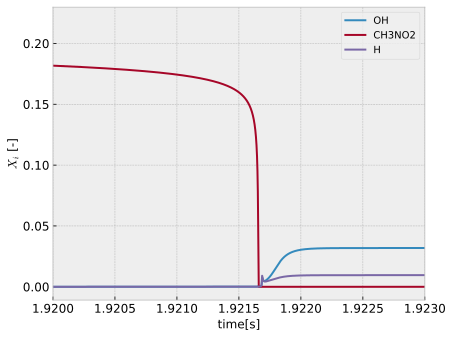

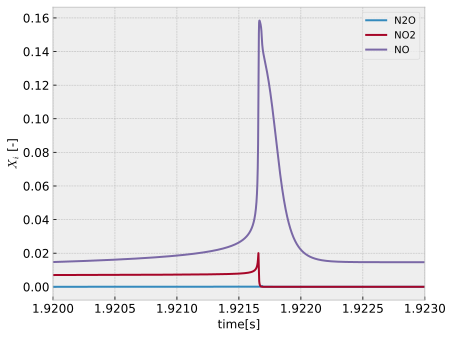

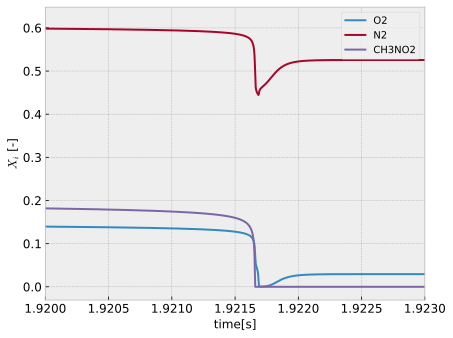

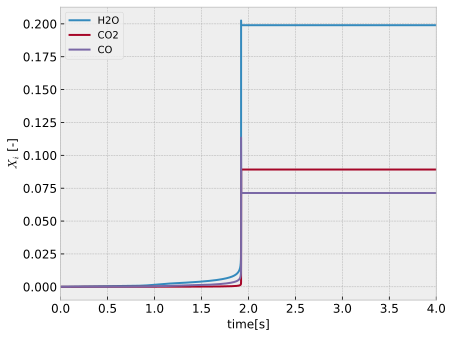

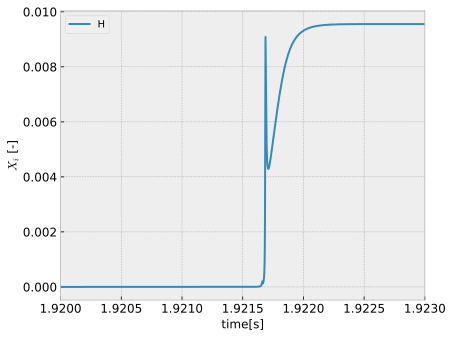

In [ ]:
plot(states_10,1)

# **phi(0.1,1.0)**

In [ ]:
npoints = 15
phi = np.linspace(0.1, 1.0, npoints)
phi

array([0.1       , 0.16428571, 0.22857143, 0.29285714, 0.35714286,
       0.42142857, 0.48571429, 0.55      , 0.61428571, 0.67857143,
       0.74285714, 0.80714286, 0.87142857, 0.93571429, 1.        ])

In [ ]:
gas = ct.Solution('Fuller.yaml')
fuel_species = 'CH3NO2'

#IGNITER
gas.TPX = 1000, ct.one_atm, 'H:1.0'
igniter = ct.Reservoir(gas)

def igniter_mdot(t):
  igniter_total = 1.0e-08
  width = 0.1  #[s]
  t0 = 1.0  #pulse peak [s]
  amplitude = igniter_total / (width * np.sqrt(2*np.pi))
  return amplitude * np.exp(-(t-t0)**2 / (2*width**2))

states_dT = []
states_dP = []

for i in range(npoints):
    gas.set_equivalence_ratio(phi=phi[i], fuel=fuel_species, oxidizer='O2:1.0, N2:3.76')
    gas.TP = 700, ct.one_atm
    gas()

    combustor = ct.Reactor(gas)
    combustor.volume = 0.0005
    igniter_mfc = ct.MassFlowController(igniter, combustor, mdot = igniter_mdot)

    sim = ct.ReactorNet([combustor])
    sim.rtol = 1.0e-16
    states_50 = ct.SolutionArray(gas, extra=['t', 'V'])

    n=0
    while sim.time < 4:
      sim.step()
      n+=1
      states_50.append(combustor.thermo.state, t=sim.time, V=combustor.mass)

    states_dT.append(states_50.T.max())
    states_dP.append(states_50.P.max()/ct.one_atm)



  gas:

       temperature   700 K
          pressure   1.0132e+05 Pa
           density   0.51755 kg/m^3
  mean mol. weight   29.728 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        3.4979e+05        1.0398e+07  J
   internal energy        1.5401e+05        4.5784e+06  J
           entropy            7682.2        2.2838e+05  J/K
    Gibbs function       -5.0277e+06       -1.4947e+08  J
 heat capacity c_p            1112.7             33079  J/K
 heat capacity c_v            833.04             24765  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2           0.21996           0.20436            -27.28
                N2           0.72409           0.76839           -24.296
            CH3NO2          0.055948          0.027248           -52.743
 

NameError: ignored

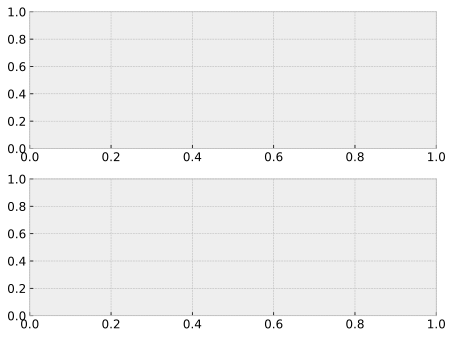

In [ ]:
##
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(phi, states_dP, 'o-')
ax1.set_xlabel(r"Equivalence ratio, $\phi$")
ax1.set_ylabel('Max Pressure (P[atm])')

ax2.plot(phi, states_dT, '.-')
ax2.set_xlabel(r"Equivalence ratio, $\phi$")
ax2.set_ylabel('Max temp (K)')
plt.savefig('summary15_0_1.png', format='png', dpi=1500)
plt.show()

# flame temperature
https://cantera.org/examples/jupyter/thermo/flame_temperature.ipynb.html

In [ ]:
# Get all of the Species objects defined in the GRI 3.0 mechanism
species = {S.name: S for S in ct.Species.listFromFile("Fuller.yaml")}

# Create an IdealGas object with species representing complete combustion
complete_species = [species[S] for S in ("CH3NO2", "O2", "N2", "CO2", "H2O", "NO")]
gas1 = ct.Solution(thermo="IdealGas", species=complete_species)

phi = np.linspace(0.1, 2.0, 50)
T_complete = np.zeros(phi.shape)
for i in range(len(phi)):
    gas1.TP = 300, ct.one_atm
    gas1.set_equivalence_ratio(phi[i], "CH3NO2", "O2:1, N2:3.76")
    gas1.equilibrate("HP")
    T_complete[i] = gas1.T

<ipython-input-92-1c8ad383d70a>:2: DeprecationWarning: Static method 'listFromFile' is renamed to 'list_from_file'. The old name will be removed after Cantera 2.6.
  species = {S.name: S for S in ct.Species.listFromFile("Fuller.yaml")}


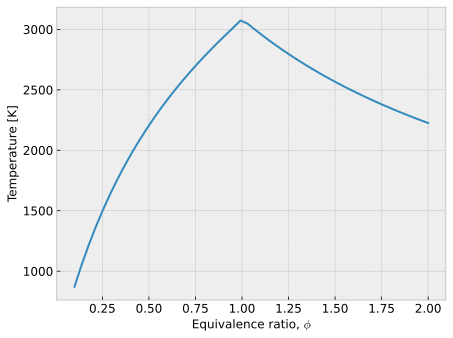

In [ ]:
plt.plot(phi, T_complete, label="complete combustion", lw=2)
plt.grid(True)
plt.xlabel(r"Equivalence ratio, $\phi$")
plt.ylabel("Temperature [K]")
plt.savefig('flame_temp.png')

# brudnopis